# Определение потенциально популярных игр для планирования рекламных кампаний

__Цели исследования__:
1. Провести анализ исторических данных о продажах игр.
2. Определить закономерности, влияющие на успешность игр.

__Используемые данные__: исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы, взятые из открытых источников.

## Оглавление

1. [Изучение данных](#1)
    <br>1.1 [Импорт библиотек, чтение файла](#1.1)
    <br>1.2 [Общая информация о данных](#1.2)
    <br>1.3 [Обработка пропущенных значений и изменение типов признаков](#1.3)
    <br>1.4 [Вывод](#1.4)
2. [Исследовательский анализ данных](#2)
    <br>2.1 [Характерное время существования платформ](#2.1)
    <br>2.2 [Изучение потенциально прибыльных платформ](#2.2)
    <br>2.3 [Связь оценок критиков и пользователей с глоабльными продажами](#2.3)
    <br>2.4 [Глобальные продажи и жанры игр](#2.4)
    <br>2.5 [Вывод](#2.5)
3. [Региональные особенности продаж игр](#3)
    <br>3.1 [Регионы и платформы](#3.1)
    <br>3.2 [Регионы и жанры](#3.2)
    <br>3.3 [Влияние возрастного рейтинга на продажи](#1.3)
    <br>3.4 [Вывод](#3.4)
4. [Статистическая проверка гипотез](#4)
    <br>4.1 [Средние пользовательские рейтинги платформ Xbox One и PC](#4.1)
    <br>4.2 [Средние пользовательские рейтинги жанров Action и Sports](#4.2)
    <br>4.3 [Вывод](#4.3)
5. [Заключение](#5)

<a id="1"></a>
## 1. Изучение данных

<a id="1.1"></a>
### 1.1. Импорт библиотек, чтение файла
Импортируем необходимые для работы библиотеки.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

Для более красивого отображения графиков создадим свою палитру и изменим размеры изображений.

In [2]:
colors = [
    "#E74C3C", "#E67E22", "#F1C40F", "#2ECC71",
    "#3498DB", "#9B59B6", "#F1948A", "#F0B27A",
    "#F7DC6F", "#82E0AA", "#85C1E9", "#C39BD3"   
]

my_palette = sns.set_palette(colors, 12)

sns.set(palette=my_palette, rc={'figure.figsize':(10, 7)})

Считаем файл в переменную `data` и проверим, что он загрузился нормально.

In [3]:
data = pd.read_csv("/datasets/games.csv")
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Приведём названия столбцов к нижнему регистру.

In [4]:
new_columns = [column.lower() for column in data.columns]
data.columns = new_columns

<a id="1.2"></a>
### 1.2. Общая информация о  данных
Выведем общую информацию о данных.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
print("Количество явных дубликатов:")
print(data.duplicated().sum())

Количество явных дубликатов:
0


Сразу заметны проблемы в данных: 
* есть пропущенные значения;
* признак `user_score` представлен не числами.

Пропуски в данных могли появиться из-за технических сбоев (например, отсутствующие названия игр), из-за отсутствия информации в открытых источниках (например, даты выхода), из-за недостатков источников данных (малое количество оценок, из-за чего нельзя посчитать оценки критиков и пользователей), из-за формальных причин (рейтинг ESRB проставляется далеко не всем играм).

Разделим признаки на категориальные и числовые. Посмотрим на уникальные значения категориальных приззнаков.

_Примечание: `critic_score` и `user_score`, которые по смыслу являются числовыми, отнесены к категориальным исключительно для удобства их дальнейшей обработки._

<a id="1.3"></a>
### 1.3. Обработка пропущенных значений и изменение типов признаков

In [7]:
cat_features = ["platform", "year_of_release", "genre", "critic_score", "user_score", "rating"]
num_features = ["na_sales", "eu_sales", "jp_sales", "other_sales"]

In [8]:
for column in cat_features:
    print(column)
    print(data[column].unique())
    print("-------------------------------------------------------------\n")

platform
['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
-------------------------------------------------------------

year_of_release
[2006. 1985. 2008. 2009. 1996. 1989. 1984. 2005. 1999. 2007. 2010. 2013.
 2004. 1990. 1988. 2002. 2001. 2011. 1998. 2015. 2012. 2014. 1992. 1997.
 1993. 1994. 1982. 2016. 2003. 1986. 2000.   nan 1995. 1991. 1981. 1987.
 1980. 1983.]
-------------------------------------------------------------

genre
['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy' nan]
-------------------------------------------------------------

critic_score
[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65.

Посмотрим на долю пропущенных значений в каждом из признаков.

In [9]:
data.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

Пропуски в столбцах `name`, `year_of_release`, `genre` заполнить нельзя. Учитывая, что пропусков здесь не так много, можно просто удалить объекты, где пропущены значения этих признаков.

In [10]:
data.dropna(subset=["name", "year_of_release", "genre"], inplace=True)
# data.isna().mean()

Пропуски в `critic_score` и `user_score` можно заменить особыми значениями, чтобы такие строки можно было сразу отбросить при дальнейшем анализе. Это позволит не вносить в выборку искажения, как, например, при замене пропусков на среднее значение или медиану.

In [11]:
data.loc[:, ["critic_score", "user_score"]] = data.loc[:, ["critic_score", "user_score"]].fillna("-1")
# data.isna().mean()

Пропуски в `rating` заменим на особое значение, чтобы в дальнейшем эти строки можно было учесть при анализе.

In [12]:
data["rating"].fillna("N/A", inplace=True)
# data.isna().mean()

Кроме того, в `user_score` встречается значение "tbd" — "подлежит уточнению". Это означает, что по каким-то причинам (например, малое количество оценок) посчитать оценку пользователей не получилось. Заменим это значение на особое значение. 

In [13]:
data["user_score"].replace("tbd", "-2", inplace=True)

Теперь можно привести столбцы с данными к числовым типам. `critic_score` принимает только целые значения, поэтому приведём его к типу `int`, а `user_score` — к типу `float`.

In [14]:
data[["critic_score", "year_of_release"]] = data[["critic_score", "year_of_release"]].astype(int)
data["user_score"] = data["user_score"].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


Теперь посчитаем суммарные продажи во всех регионах. Результат запишем в столбец `global_sales`.

In [15]:
data["global_sales"] = data[num_features].sum(axis=1)

In [16]:
flag = False

In [17]:
if not flag:
    data = data[list(data.columns[0:8]) + [data.columns[-1]] + list(data.columns[8:-1])]
    flag = True

data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,global_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,-1,-1.0,N/A
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,32.77,80,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,31.38,-1,-1.0,N/A


<a id="1.4"></a>
### 1.4. Вывод
* в данных были обнаружены пропущенные значения;
* приведены возможные причины их появления, обоснование выбранному способу избавления от них;
* признаки `year_of_release`, `critic_score`, `user_score` приведены к более подходящим типам данных;
* добавлен признак `global_sales` — глобальные продажи (в млн. копий).

<a id="2"></a>
## 2. Исследовательский анализ данных

<a id="2.1"></a>
### 2.1. Характерное время существования платформ
Построим гистограмму распределения выпущенных игр по годам. 

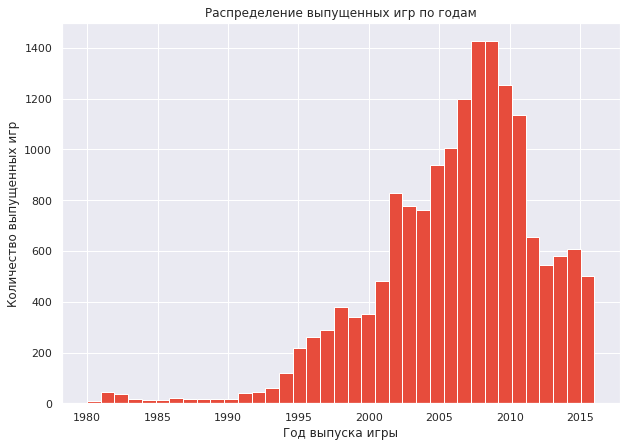

In [18]:
data["year_of_release"].hist(bins=37);
plt.xlabel("Год выпуска игры")
plt.ylabel("Количество выпущенных игр")
plt.title("Распределение выпущенных игр по годам");

Пик выпуска игр пришёлся на 2007-2008 гг. При этом подавляющее большинство игр были выпущены после 2000-го года.

Сгруппируем данные по платформам и годам выпуска игр. Будем считать суммарное количество проданных копий для каждой платформы за каждый представленный год. Отберём платформы с наибольшими суммарными продажами.

In [19]:
years_pivot = data.pivot_table(index=["platform", "year_of_release"], 
                               values=["global_sales"], 
                               aggfunc=["sum", "count"])

years_pivot.columns = ["sales_per_year", "count"]

most_sales_platforms = (years_pivot["sales_per_year"].sum(level="platform")
                                                     .sort_values(ascending=False)[:11]
                                                     .index
                                                     .values)

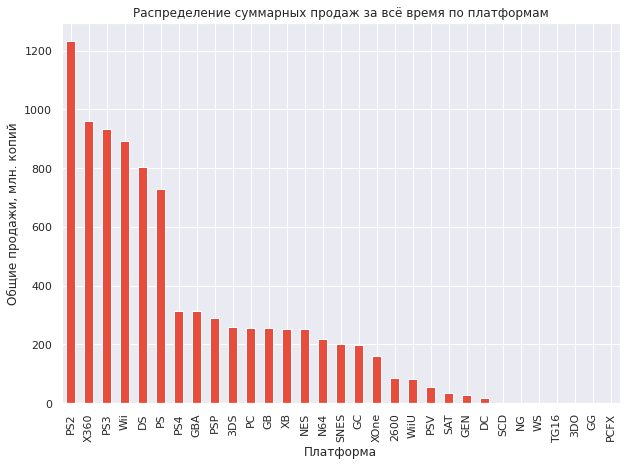

In [20]:
years_pivot["sales_per_year"].sum(level="platform").sort_values(ascending=False).plot(kind="bar")
plt.title("Распределение суммарных продаж за всё время по платформам")
plt.xlabel("Платформа")
plt.ylabel("Общие продажи, млн. копий");

Построим графики распределения продаж для платформ с наибольшими суммарными продажами. 

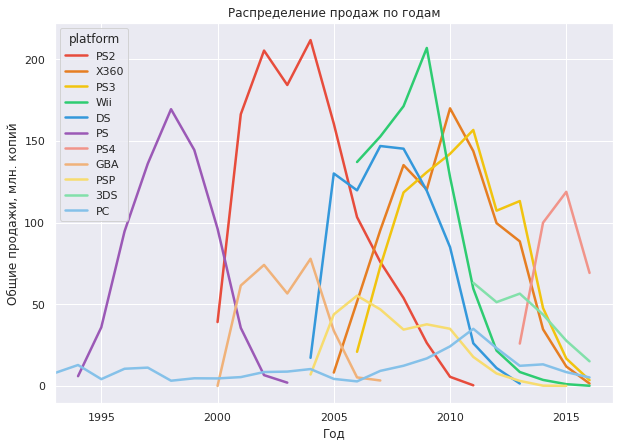

In [21]:
years_pivot.loc[most_sales_platforms, "sales_per_year"].unstack(level=0).sort_index().plot(lw=2.5)

plt.xlim((1993, 2017))
plt.title("Распределение продаж по годам")
plt.xlabel("Год")
plt.ylabel("Общие продажи, млн. копий");

По графикам можно определить среднюю "продолжительность жизни" платформы, она составляет примерно 10 лет.

Некоторые особенности, которые можно заметить на графиках:
* одна платформа существует гораздо дольше, чем остальные, — PC (персональный компьютер);
* продажи игр для мобильных платформ (GBA, PSP) существенно меньше, чем продажи для "настольных" устройств).

Поскольку средний срок существования платформы около десяти лет, то в дальнейшем имеет смысл ориентироваться на платформы, которые просуществуют ещё хотя бы половину этого срока. Посмотрим на распределение продаж для платформ, которые удовлетворяют этому условию.

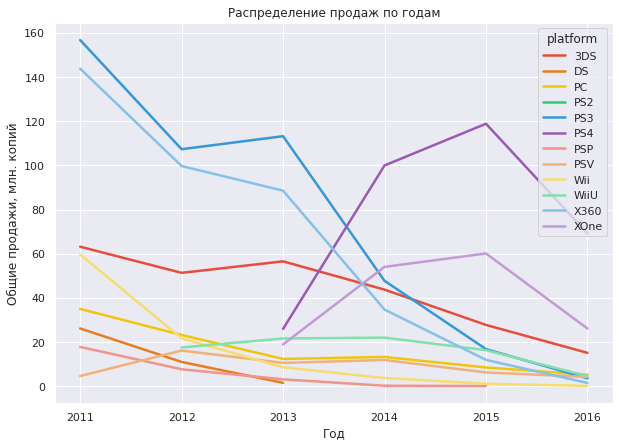

In [22]:
years_pivot.query("year_of_release >= 2011").loc[:, "sales_per_year"].unstack(level=0).sort_index().plot(lw=2.5)
plt.title("Распределение продаж по годам")
plt.xlabel("Год")
plt.ylabel("Общие продажи, млн. копий");

В тройку лидеров по количеству проданных копий в 2016-м году входят платформы PS4, XOne и 3DS. Все эти платформы появились не позднее 2011-го, поэтому их можно использовать для дальнейшего анализа. Кроме того, платформа WiiU появилась примерно в то же время, а значит, является актуальной, потому её тоже будем использовать. И наконец, платформа-"долгожитель" PC — продажи для неё относительно невелики, зато она существует уже не одно десятилетие и, по всей видимости, будет существовать и далее. Её тоже будем использовать для анализа. 

Таким образом, список интересущих нас платформ будет следующим: PS4, XOne, 3DS, WiiU, PC.

<a id="2.2"></a>
### 2.2. Изучение потенциально прибыльных платформ
Сохраним названия платформ из предыдущего пункта в список и отфильтруем данные по году выпуска игр. 

In [23]:
actual_platforms = ["PS4", "XOne", "PC", "WiiU", "3DS"]

actual_data = data.query("year_of_release >= 2011")

Построим диаграмму размаха для глоабльных продаж в зависимости от платформы.

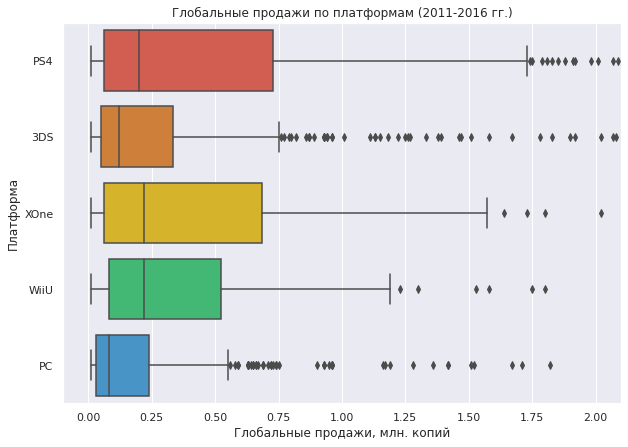

In [24]:
sns.boxplot(x="global_sales",
            y="platform",
            data=actual_data.query("platform in @actual_platforms"),
            orient="h")

plt.title("Глобальные продажи по платформам (2011-2016 гг.)")
plt.xlabel("Глобальные продажи, млн. копий")
plt.ylabel("Платформа")
plt.xlim((-0.1, 2.1));

In [25]:
print("Доля игр, проданных в количестве более 1 млн. копий")
for p in actual_platforms:
    print(f"{p:<10} {actual_data.query('(global_sales > 1) & (platform == @p)').shape[0]/actual_data.query('platform in @actual_platforms').shape[0]:.2%}")

Доля игр, проданных в количестве более 1 млн. копий
PS4        4.62%
XOne       3.02%
PC         1.07%
WiiU       1.19%
3DS        2.85%


Максимальная медиана глобальных продаж у двух платформ: XOne и WiiU. Затем идёт PS4 с очень тяжёлым хвостом справа, для этой платформы максимальна доля игр, проданных в количестве более 1  млн. копий (более 4%). Меньше всего продаж у PC.

<a id="2.3"></a>
### 2.3. Связь оценок критиков и пользователей с глобальными продажами
Посчитаем коэффициенты корреляции Пирсона между оценкой критиков и продажами (столбец `critic_sales_corr`), между оценкой пользователей и продажами (столбец `user_sales_corr`) для потенциально прибыльных платформ.

In [26]:
d = {"critic_score" : [], "user_score": []}

for p in actual_platforms:
    for score in ["critic_score", "user_score"]:
        
        if score == "critic_score":
            x = actual_data.query("(platform == @p) & (critic_score >= 0)")[score]
            y = actual_data.query("(platform == @p) & (critic_score >= 0)")["global_sales"]
        else:
            x = actual_data.query("(platform == @p) & (user_score >= 0)")[score]
            y = actual_data.query("(platform == @p) & (user_score >= 0)")["global_sales"]

        d[score].append(x.corr(y))

correlations = pd.DataFrame(data=d, index=actual_platforms).round(3)
correlations.columns = ["critic_sales_corr", "user_sales_corr"]
correlations

,critic_sales_corr,user_sales_corr
PS4,0.407,-0.032
XOne,0.417,-0.069
PC,0.314,-0.049
WiiU,0.348,0.400
3DS,0.349,0.222


Как видно из таблицы, связь между оценками критиков и количеством проданных копий есть, но довольно слабая. Связь между оценками пользователей и количеством проданных копий для некоторых платформ практически отстутсвует, для некоторых — очень слабая. Построим диаграммы рассеяния для наглядности.

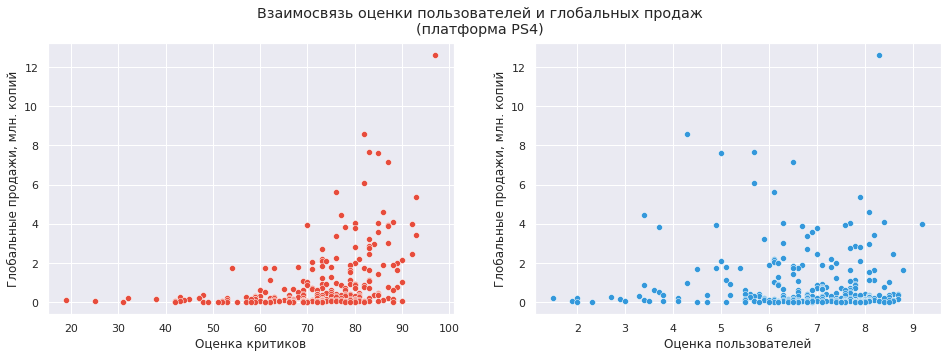

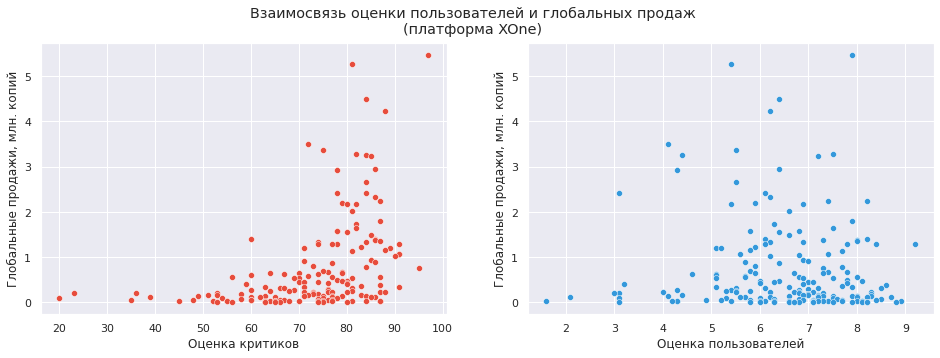

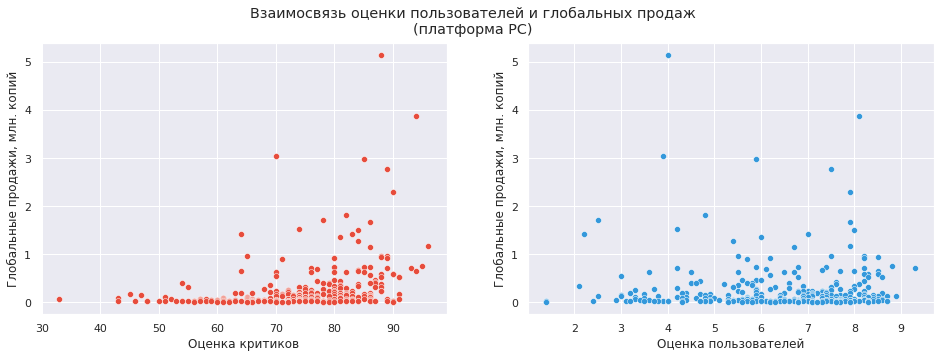

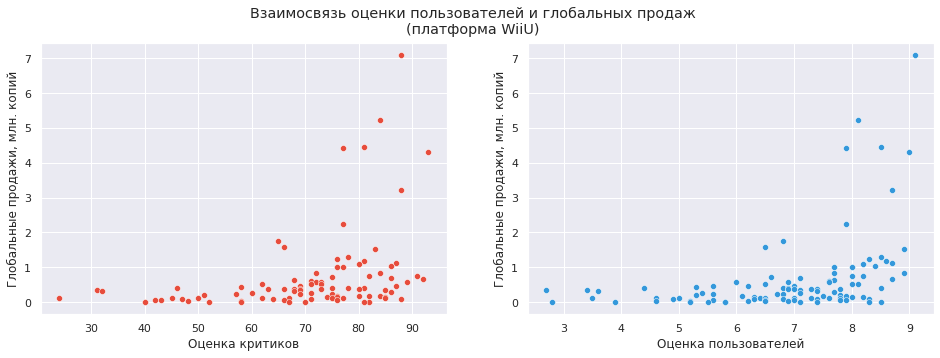

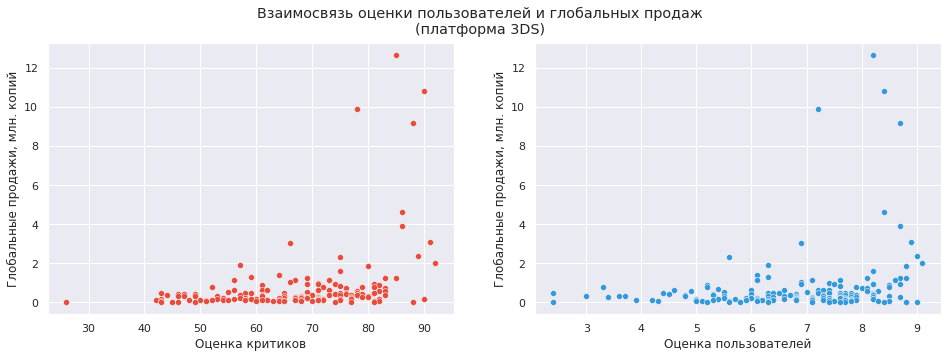

In [27]:
for p in actual_platforms:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

    for score in ["critic_score", "user_score"]:
        
        if score == "critic_score":
            x = actual_data.query("(platform == @p) & (critic_score >= 0)")[score]
            y = actual_data.query("(platform == @p) & (critic_score >= 0)")["global_sales"]
            color = "#E74C3C"
            plt.subplot(1, 2, 1)
            descr = "критиков"
        else:
            x = actual_data.query("(platform == @p) & (user_score >= 0)")[score]
            y = actual_data.query("(platform == @p) & (user_score >= 0)")["global_sales"]
            color = "#3498DB"
            plt.subplot(1, 2, 2)
            descr = "пользователей"
            
        sns.scatterplot(x=x, y=y, color=color)
        plt.suptitle(f"Взаимосвязь оценки {descr} и глобальных продаж\n(платформа {p})")
        plt.xlabel(f"Оценка {descr}")
        plt.ylabel(f"Глобальные продажи, млн. копий")
        if score != "critic_score":
            plt.show()

Диаграммы рассеяния иллюстрируют отсутствие сильной связи между переменными.

<a id="2.4"></a>
### 2.4. Глобальные продажи и жанры игр
Построим диаграммы размаха для глобальных продаж в зависимости от жанра игры.

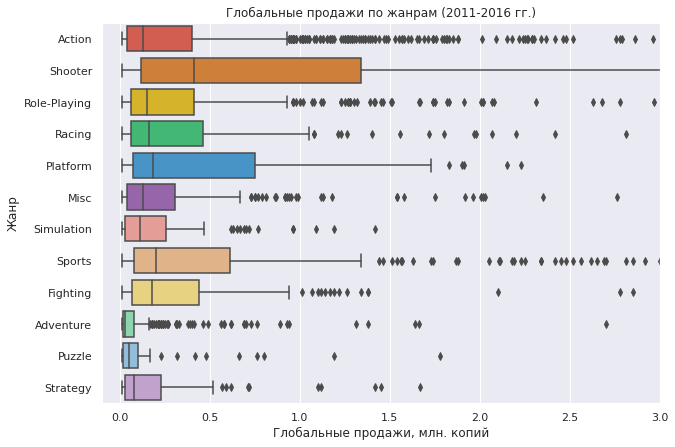

In [28]:
sns.boxplot(x="global_sales", y="genre", data=actual_data)
plt.title("Глобальные продажи по жанрам (2011-2016 гг.)")
plt.xlabel("Глобальные продажи, млн. копий")
plt.ylabel("Жанр")
plt.xlim((-0.1, 3));

Наиболее продаваемые игры относятся к жанру "Shooter", затем идут игры жанров "Sports" и "Fighting". Хуже всего продаются игры, принадлежащие к жанрам "Adventure", "Strategy" и "Puzzle".

<a id="2.5"></a>
### 2.5. Вывод
* определено характерное время существования платформ, оно составляет примерно 10 лет;
* определён список потенциально прибыльных платформ: PS4, XOne, 3DS, WiiU, PC;
* наибольшая медиана глобальных продаж у XOne, наименьшая — у PC;
* взаимосвязь между глобальными продажами и оценками критиков слабая, между глобальными продажами и оценками пользователей практически отсутствует;
* самые продаваемые игры относятся к жанрам "Shooter", "Sports" и "Fighting", наименее продаваемые — "Adventure", "Strategy" и "Puzzle".

<a id="3"></a>
## 3. Региональные особенности продаж игр
Посмотрим, как рапределены продажи в разных регионах по платформам и жанрам.

<a id="3.1"></a>
### 3.1. Регионы и платформы

In [29]:
sales = actual_data.pivot_table(index="platform", 
                                values=["na_sales", "eu_sales", "jp_sales"], 
                                aggfunc="sum")
sales.columns = ["Europe", "Japan", "Northern America"]
sales.head()

,Europe,Japan,Northern America
platform,,,
3DS,61.27,100.62,82.65
DS,9.24,8.04,18.86
PC,56.70,0.00,29.88
PS2,0.13,0.09,0.13
PS3,163.10,49.39,168.26


In [30]:
top_platforms = [
    sales["Northern America"].sort_values(ascending=False)[:5],
    sales["Europe"].sort_values(ascending=False)[:5],
    sales["Japan"].sort_values(ascending=False)[:5]
]

regions = {
    "Northern America": "Северной Америке", 
    "Europe": "Европе", 
    "Japan": "Японии"
}

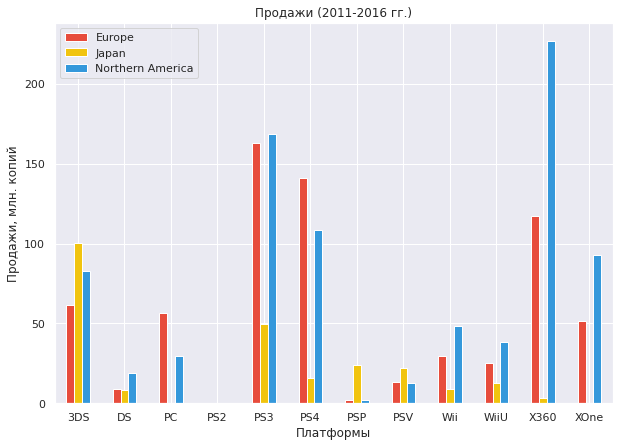

In [31]:
sales.plot(kind="bar", color=colors[:5:2], rot=0)
plt.xlabel("Платформы")
plt.ylabel("Продажи, млн. копий")
plt.title("Продажи (2011-2016 гг.)");

Теперь посмотрим, какие платформы входят в топ-5 по продажам в каждом регионе.

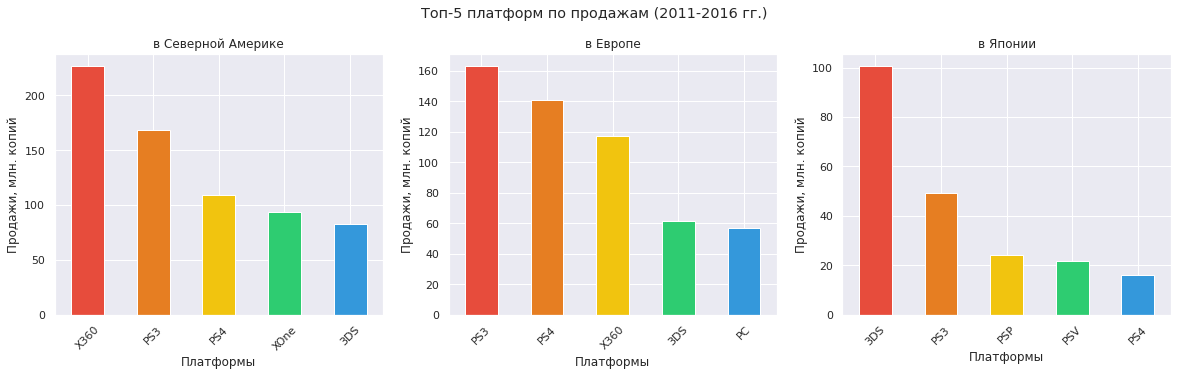

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))


for tp, region, ax in zip(top_platforms, regions.values(), axes.flat):
    tp.plot(kind="bar", color=colors[:6], rot=45, ax=ax)
    ax.set_title(f"в {region}")
    
plt.subplots_adjust(top=0.85)
plt.suptitle("Топ-5 платформ по продажам (2011-2016 гг.)")
plt.setp(axes, xlabel="Платформы")
plt.setp(axes, ylabel="Продажи, млн. копий");

Хорошо видны региональные особенности продаж. 

В Северной Америке больше всего продаж за 5 лет приходится на X360, далее идёт PS3. Это устаревающие платформы, с каждым годом для них выходит всё меньше игр. Далее идут перспективные PS4, XOne, и 3DS. 

В Европе лидерство по продажам также за PS3, однако почти столько же продаж у PS4. В топ-5 попали ещё две перспективные платформы, 3DS и PC.

В Японии верхнюю позицию занимает 3DS, из списка перспективных платформ здесь ещё есть PS4. В целом же, в топ-5 на японском рынке попали только платформы, выпускаемые японскими компаниями. Стоит отметить, что здесь намного популярнее карманные приставки (PSV и PSP).

<a id="3.2"></a>
### 3.2. Регионы и жанры
Посмотрим на популярные жанры.

In [33]:
genres = actual_data.pivot_table(index="genre", values=["na_sales", "eu_sales", "jp_sales"], aggfunc="sum")
genres.columns = ["Europe", "Japan", "Northern America"]

In [34]:
genres.head()

,Europe,Japan,Northern America
genre,,,
Action,199.12,63.62,230.92
Adventure,13.96,12.07,14.76
Fighting,16.24,12.38,31.63
Misc,39.72,17.60,69.69
Platform,30.07,12.13,38.28


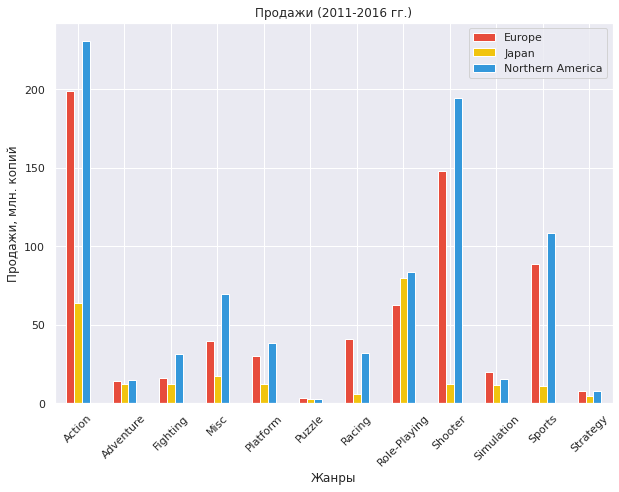

In [35]:
genres.plot(kind="bar", color=colors[:5:2], rot=45)
plt.xlabel("Жанры")
plt.ylabel("Продажи, млн. копий")
plt.title("Продажи (2011-2016 гг.)");

Выделим топ-5 жанров в каждом регионе. 

In [36]:
top_genres = [
    genres["Northern America"].sort_values(ascending=False)[:5],
    genres["Europe"].sort_values(ascending=False)[:5],
    genres["Japan"].sort_values(ascending=False)[:5]
]

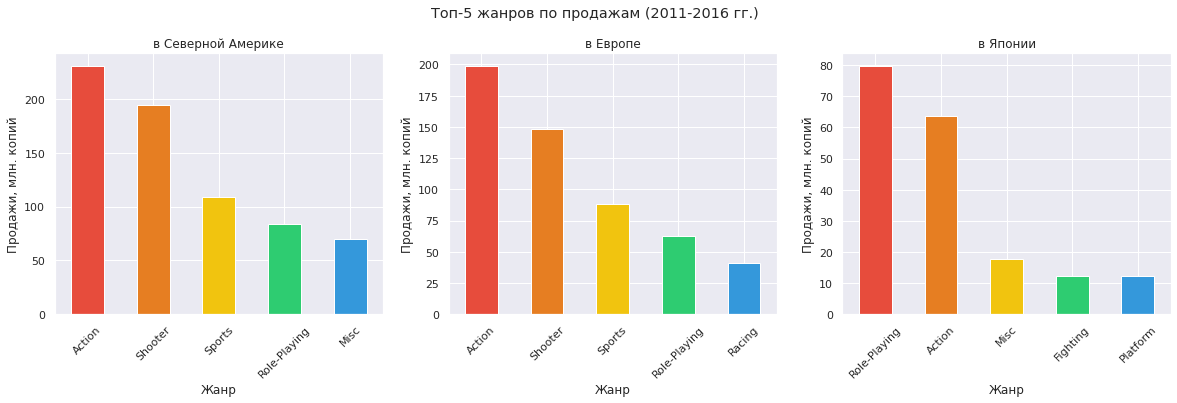

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

genres_set = set()
for tg, region, ax in zip(top_genres, regions.values(), axes.flat):
    tg.plot(kind="bar", color=colors[:6], rot=45, ax=ax)
    ax.set_title(f"в {region}")
    genres_set = genres_set | set(tg.index.values)
    
plt.subplots_adjust(top=0.85)
plt.suptitle("Топ-5 жанров по продажам (2011-2016 гг.)")
plt.setp(axes, xlabel="Жанр")
plt.setp(axes, ylabel="Продажи, млн. копий");

Здесь тоже заметны региональные особенности. 

В Северной Америке и Европе топ-5 жанров практически идентичны (в Северной Америке пятое место у жанра Misc, а в Европе — у Racing). Верхнюю строчку занимает Action.

В Японии жанр Action также входит в пятёрку лидеров по продажам, однако он занимает второе место, первое же у Role-Playing. Кроме того, в топ-5 входят жанры Fighting и Platform. 

<a id="3.3"></a>
### 3.3. Влияние возрастного рейтинга на продажи
Посмотрим на суммарные продажи игр, принадлежащих к разным возрастным рейтингам, в каждом регионе.

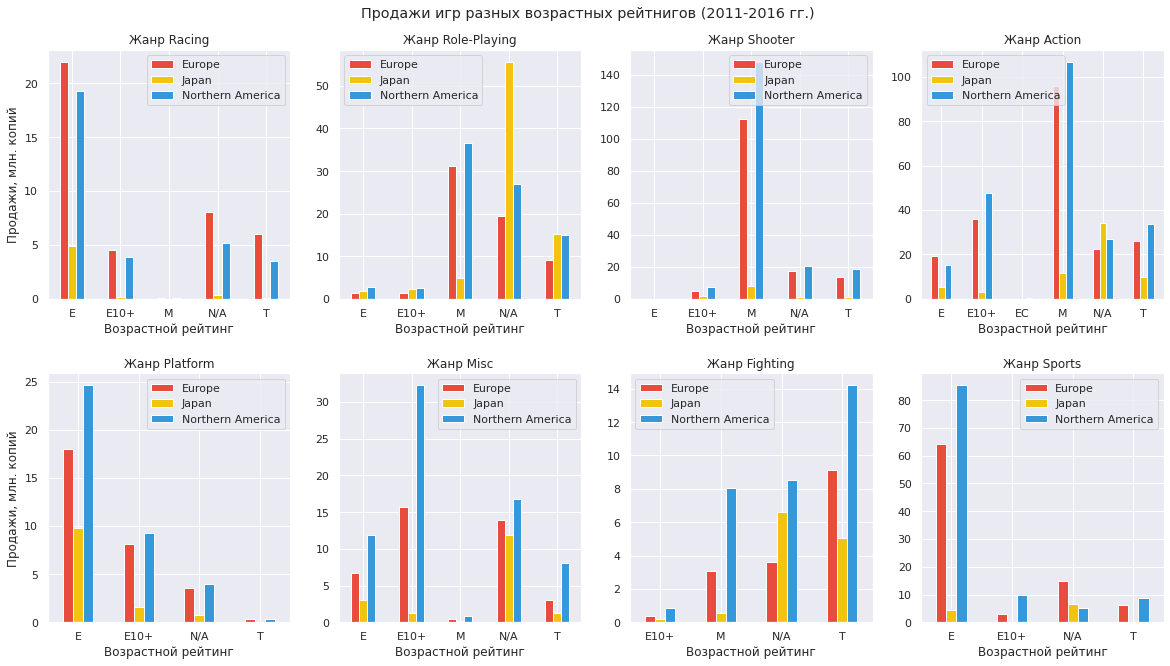

In [38]:
genre_rating_data = actual_data.pivot_table(index=["genre", "rating"], 
                                            values=["na_sales", "eu_sales", "jp_sales"], 
                                            aggfunc="sum")
genre_rating_data.columns = ["Europe", "Japan", "Northern America"]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for g, ax in zip(genres_set, axes.flat):
    genre_rating_data.loc[g, :].plot(kind="bar", 
                                     color=colors[:5:2], 
                                     rot=0, 
                                     ax=ax)
    ax.set_title(f"Жанр {g}")
    
plt.suptitle("Продажи игр разных возрастных рейтнигов (2011-2016 гг.)")
plt.subplots_adjust(top=0.92, hspace=0.3)
plt.setp(axes[:, :], xlabel="Возрастной рейтинг")
plt.setp(axes[:, 0], ylabel="Продажи, млн. копий");

В жанрах Action и Shooter преобладают продажи игр рейтинга "M", но только для Северной Америки и Европы, в Японии преобладают игры без рейтинга. Возможно это связано с более жёстким регулированием при продаже таких игр или в этом регионе преобладают игры, которые до ESRB не добираются.  Аналогичные выводы можно сделать для Role-Playing-игр. 

В жанрах Sports, Racing, Platform преобладают игры с рейтингом "E". Это логично, поскольку игры этих жанров, как правило включают, в себя меньше сцен насилия в отличие от тех же шутеров.

**Резюме:** shooter и action имеют как правило рейтинг "M" и продаются в наибольшем количестве в Северной Америке и Европе; sports, racing, platform имеют рейтинги "E", "T" и относительно хорошо продаются во всех регионах. 

Построим график суммарных продаж игр в зависимости от возрастного рейтинга в разных регионах.

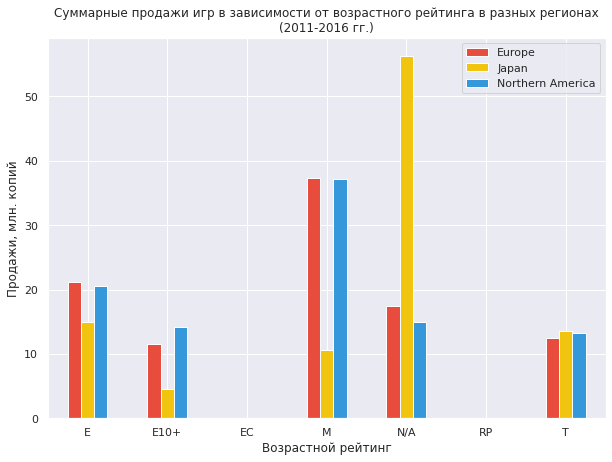

In [39]:
esrb = actual_data.pivot_table(index=["rating"], 
                               values=["na_sales", "eu_sales", "jp_sales"], 
                               aggfunc="sum")

esrb = (esrb/esrb.sum()*100).round(1)
esrb.columns = ["Europe", "Japan", "Northern America"]
esrb.plot(kind="bar", color=colors[:5:2], rot=0)
plt.xlabel("Возрастной рейтинг")
plt.ylabel("Продажи, млн. копий")
plt.title("Суммарные продажи игр в зависимости от возрастного рейтинга в разных регионах\n(2011-2016 гг.)");

В Северной Америке и Европе наибольшее количество проданных игр относится к рейтингу "M", в Японии — без указания рейтинга. Последнее может быть связано с тем, что эти игры просто не попадают в регионы, где необходима оценка ESRB.

<a id="3.4"></a>
### 3.4. Вывод

* тройка лидирующих платформ по продажам в Северной Америке и Европе совпадает: X360, PS3, PS4;
* в Японии наибольшие продажи у платформы 3DS, также в лидерах "карманные" платформы PSP и PSV;
* наиболее продаваемые жанры в Северной Америке и Европе совпадают — Action и Shooter, в Японии лучше всего продаются Role-Playing и Action;
* shooter и action имеют как правило рейтинг "M" и продаются в наибольшем количестве в Северной Америке и Европе; sports, racing, platform имеют рейтинги "E", "T" и относительно хорошо продаются во всех регионах;
* игры, имеющие рейтинг "M" имеют наибольшее количество продаж в Северной Америке и Европе, в Японии лидируют игры без указания рейтинга.

<a id="4"></a>
## 4. Статистическая проверка гипотез

<a id="4.1"></a>
### 4.1. Средние пользовательские рейтинги платформ Xbox One и PC
Проверим гипотезу о равенстве средних оценках пользователей для игр, выходящих на платформах Xbox One и PC.

In [40]:
xone = actual_data.query("(platform == 'XOne') & (user_score >= 0)")["user_score"].values
pc = actual_data.query("(platform == 'PC') & (user_score >= 0)")["user_score"].values
xone.mean(), pc.mean()

(6.521428571428572, 6.451791530944625)

Выборочные средние близки. Сформулируем нулевую и альтернативную гипотезы.

$H_0$: cредние пользовательские рейтинги платформ Xbox One и PC одинаковы

$H_a$: cредние пользовательские рейтинги платформ Xbox One и PC различны

$H_0$ — это гипотеза о равенстве среднего двух генеральных совокупностей. Будем считать, что дисперсии у выборок, по которым будем проверять гипотезу, равны. Уровню значимости ${\alpha}$ присвоим значение `0.05`.  

In [41]:
alpha = 0.05
results = st.ttest_ind(xone, pc)

if results.pvalue < alpha:
    print(f"p-value: {results.pvalue}")
    print("Отвергаем нулевую гипотезу")
else:
    print(f"p-value: {results.pvalue}")
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 0.6267602271422398
Не получилось отвергнуть нулевую гипотезу


Тест показал, что данные не противоречат гипотезе $H_0$, поэтому отвергнуть её нельзя. Значит, cредние пользовательские рейтинги платформ Xbox One и PC, скорее всего, одинаковы.

<a id="4.2"></a>
### 4.2. Средние пользовательские рейтинги жанров Action и Sports
Проверим гипотезу о том, средние пользовательские рейтинги жанров Action и Sports разные. Будем действовать почти аналогично п. 4.1, однако учтём, что в нулевой гипотезе должно проверяться _равенство_ рейтингов.

In [42]:
action = actual_data.query("(genre == 'Action') & (user_score >= 0)")["user_score"].values
sports = actual_data.query("(genre == 'Sports') & (user_score >= 0)")["user_score"].values
action.mean(), sports.mean()

(6.775903614457831, 5.650813008130081)

Выборочные средние отличаются, средняя оценка Action выше, чем средняя оценка Sports. Сформулируем гипотезы $H_0$ и $H_a$, проведём статистический тест. Уровень значимости 𝛼 зафиксируем на 0.05.

$H_0$: средние пользовательские рейтинги жанров Action и Sports одинаковы

$H_a$: средние пользовательские рейтинги жанров Action и Sports различны

In [43]:
alpha = 0.05
results = st.ttest_ind(action, sports)

if results.pvalue < alpha:
    print(f"p-value: {results.pvalue}")
    print("Отвергаем нулевую гипотезу")
else:
    print(f"p-value: {results.pvalue}")
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 5.1974550252152054e-24
Отвергаем нулевую гипотезу


Тест показал, что данные противоречат гипотезе $H_0$, поэтому отвергаем её. Таким образом, средняя пользовательская оценка игр жанра Action, скорее всего, выше, чем у игр жанра Sports.

<a id="4.3"></a>
### 4.3. Вывод
* проведены статистические проверки двух гипотез;
* различие средних пользовательских оценок игр, выпускаемых на платформах Xbox One и PC, __статистически не значимы__;
* различие средних пользовательских оценок игр жанра Action __статистически значимо__ выше, чем у игр жанра Sports.

<a id="5"></a>
## 5. Заключение
Основные выводы по итогам исследования:

1) Потеннциально прибыльные платформы PS4, XOne (наибольшая медиана продаж в млн. копий), PC, 3DS во всех регионах. В Японии значительную роль играют "карманные" платформы (PSP, PSV).

2) Связи продаж с оценками критиков и пользователей почти нет, этот фактор не является значимым при проведении рекламной кампании.

3) В Северной Америке и Европе наиболее популярны игры жанров Shooter и Action, получивший возрастной рейтинг "M" ("для взрослых").

4) В Японии наибольшей популярностью пользуются игры жанра Role-Playing без указанного рейтинга. Возможная причина — это игры, выпущенные японскими компаниями для японского рынка.

5) Во всех регионах достаточно заметную популярность имеют игры жанров Sports, Racing, Platform, продающиеся с рейтингами "E" ("для всех") "T" ("для подростков").

**Учитывая всё перечисленное, можно предположить, что наибольшую прибыль в 2017-м году принесут:**

* во-первых, игры жанров Shooter и Action с рейтингом "M", выпущенные для PS4, XOne, PC и ориентированные на североамериканский и европейский рынки;
* во-вторых, игры жанра Role-Playing, выпущенные для PS4, 3DS и ориентированные на японский рынок;
* в-третьих, игры жанров Sports, Racing, Platform с рейтингами "E" и "T", выпущенные для PS4, XOne, PC, 3DS, для всех регионов.